### Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, '..')

In [3]:
import re
import torch
import pandas as pd
from tqdm import tqdm
from underthesea import word_tokenize
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from src.model.utils import load_file, save_file
from src.model.data import TextDataset
from src.model.model import BertClassifier
from src.model.train import train, test, plot_learning_curve

### Preparing dataset

In [4]:
df = pd.read_csv('../data/data_version1/combined_data.csv')

In [5]:
df.head()

,reason_combind,specialist_name,source_file
0,mất ngủ,thần kinh,reason_specialist - thần kinh.csv
1,rối loạn thần kinh thực vật,thần kinh,reason_specialist - thần kinh.csv
2,đau đầu,thần kinh,reason_specialist - thần kinh.csv
3,"đau đầu,đau sau ngực gần phổi",thần kinh,reason_specialist - thần kinh.csv
4,co giật 3 lần,thần kinh,reason_specialist - thần kinh.csv


In [6]:
df.specialist_name.unique(), len(df.specialist_name.unique())

(array(['thần kinh', 'vô sinh - hiếm muộn', 'nhi khoa', 'thận - tiết niệu',
        'ung bướu', 'hô hấp - phổi', 'chuyên khoa mắt', 'cơ xương khớp',
        'tim mạch', 'tiêu hoá', 'sức khỏe tâm thần', 'nội khoa',
        'tiểu đường - nội tiết', 'tai mũi họng', 'nam học', 'da liễu',
        'sản phụ khoa'], dtype=object),
 17)

In [7]:
# Merge 'chuyên khoa cột sống' to 'cơ xương khớp'
df['specialist_name'] = df['specialist_name'].replace('cột sống', 'cơ xương khớp')

# Verify the changes
print("Updated specialist names:")
print(df.specialist_name.unique())

Updated specialist names:
['thần kinh' 'vô sinh - hiếm muộn' 'nhi khoa' 'thận - tiết niệu'
 'ung bướu' 'hô hấp - phổi' 'chuyên khoa mắt' 'cơ xương khớp' 'tim mạch'
 'tiêu hoá' 'sức khỏe tâm thần' 'nội khoa' 'tiểu đường - nội tiết'
 'tai mũi họng' 'nam học' 'da liễu' 'sản phụ khoa']


In [8]:
# Merge 'khám tổng quát' to 'nội khoa'
df['specialist_name'] = df['specialist_name'].replace('khám tổng quát', 'nội khoa')

# Verify the changes
print("Updated specialist names after merging 'khám tổng quát' to 'nội khoa':")
print(df.specialist_name.unique())

Updated specialist names after merging 'khám tổng quát' to 'nội khoa':
['thần kinh' 'vô sinh - hiếm muộn' 'nhi khoa' 'thận - tiết niệu'
 'ung bướu' 'hô hấp - phổi' 'chuyên khoa mắt' 'cơ xương khớp' 'tim mạch'
 'tiêu hoá' 'sức khỏe tâm thần' 'nội khoa' 'tiểu đường - nội tiết'
 'tai mũi họng' 'nam học' 'da liễu' 'sản phụ khoa']


In [9]:
# Drop rows with NaN values
df = df.dropna().reset_index(drop=True)

# Verify the result
print(f"Dataset shape after dropping NaN values: {df.shape}")
print(f"Number of NaN values remaining: {df.isna().sum().sum()}")

Dataset shape after dropping NaN values: (53309, 3)
Number of NaN values remaining: 0


In [10]:
df

,reason_combind,specialist_name,source_file
0,mất ngủ,thần kinh,reason_specialist - thần kinh.csv
1,rối loạn thần kinh thực vật,thần kinh,reason_specialist - thần kinh.csv
2,đau đầu,thần kinh,reason_specialist - thần kinh.csv
3,"đau đầu,đau sau ngực gần phổi",thần kinh,reason_specialist - thần kinh.csv
4,co giật 3 lần,thần kinh,reason_specialist - thần kinh.csv
...,...,...,...
53304,kiểm tra tử cung và buồng trứng,sản phụ khoa,reason_specialist - sản phụ khoa.csv
53305,vài tháng có kinh 1 lần,sản phụ khoa,reason_specialist - sản phụ khoa.csv
53306,tôi đi khám sức khoẻ định kỳ bị viêm lộ tuyến,sản phụ khoa,reason_specialist - sản phụ khoa.csv
53307,"em bị ngứa rát âm đạo, châm chích khó chịu, mu...",sản phụ khoa,reason_specialist - sản phụ khoa.csv


In [11]:
label_encoder = LabelEncoder()
label_encoder.fit(df['specialist_name'])
labels = label_encoder.transform(df['specialist_name'])

In [12]:
save_file('../models/bert/labels.pkl', labels)
save_file('../models/bert/label_encoder.pkl', label_encoder)

In [13]:
input_text = df['reason_combind']

In [14]:
# Function to remove punctuation except apostrophe and Vietnamese diacritical marks
def clean_text(text):
    if isinstance(text, str):
        # Keep Vietnamese characters, letters, numbers, spaces, apostrophes
        # Don't remove diacritical marks like: à, á, â, ã, è, é, ê, ì, í, ò, ó, ô, õ, ù, ú, ý, ă, đ, ĩ, ũ, ơ, ư, ạ, ả, ấ, ầ, ẩ, ẫ, ậ, ắ, ằ, ẳ, ẵ, ặ, ẹ, ẻ, ẽ, ế, ề, ể, ễ, ệ, ỉ, ị, ọ, ỏ, ố, ồ, ổ, ỗ, ộ, ớ, ờ, ở, ỡ, ợ, ụ, ủ, ứ, ừ, ử, ữ, ự, ỳ, ỵ, ỷ, ỹ
        # Remove other punctuation like: !"#$%&()*+,-./:;<=>?@[\]^_`{|}~
        text = re.sub(r'[^\w\s\'\u00C0-\u1EF9]', ' ', text)
        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# Apply the cleaning function to the input text
input_text = input_text.apply(clean_text)
print("Text cleaned of punctuation except apostrophes and Vietnamese diacritical marks")
print(input_text.iloc[0])

Text cleaned of punctuation except apostrophes and Vietnamese diacritical marks
mất ngủ


In [15]:
input_text

0                                                mất ngủ
1                         rối loạn thần kinh thực vật
2                                                 đau đầu
3                        đau đầu đau sau ngực gần phổi
4                                          co giật 3 lần
                               ...                        
53304                      kiểm tra tử cung và buồng trứng
53305                              vài tháng có kinh 1 lần
53306        tôi đi khám sức khoẻ định kỳ bị viêm lộ tuyến
53307    em bị ngứa rát âm đạo châm chích khó chịu muốn...
53308                                   cấy que tranh thai
Name: reason_combind, Length: 53309, dtype: object

In [16]:
# Remove more than one consecutive instance of the letter 'x'
def remove_consecutive_x(text):
    if isinstance(text, str):
        # Replace multiple consecutive 'x' or 'X' with a single 'x' or 'X'
        text = re.sub(r'[xX]{2,}', lambda m: m.group(0)[0], text)
        return text
    return ""

# Apply the function to the input text
input_text = input_text.apply(remove_consecutive_x)
print("Text with consecutive 'x' characters removed:")
print(input_text.iloc[0])

Text with consecutive 'x' characters removed:
mất ngủ


In [17]:
# Replace multiple spaces with a single space
def clean_spaces(text):
    if isinstance(text, str):
        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# Apply the cleaning function to the input text
input_text = input_text.apply(clean_spaces)
print("Text with multiple spaces cleaned:")
print(input_text.iloc[0])

Text with multiple spaces cleaned:
mất ngủ


In [ ]:
# Apply word tokenization to each text in the dataset
def tokenize_text(text):
    if isinstance(text, str):
        # Apply underthesea word tokenization with format="text"
        # Example output: 'Chàng_trai 9X Quảng_Trị khởi_nghiệp từ nấm sò'
        tokenized = word_tokenize(text, format="text")
        return tokenized
    return ""

# Apply the tokenization function to the input text
input_text = input_text.apply(tokenize_text)
print("Text after word tokenization:")
print(input_text.iloc[0])

In [18]:
len(input_text)

53309

In [19]:
tokenizer = AutoTokenizer.from_pretrained("../models/gte")

In [20]:
tokens = [
    tokenizer(
        i, padding='max_length', max_length=256,
        truncation=True, return_tensors="pt"
    )
    for i in tqdm(input_text)
]

100%|███████████████████████████████████| 53309/53309 [00:14<00:00, 3719.43it/s]


In [21]:
save_file('../data/training/tokens.pkl', tokens)

### Training

In [22]:
tokens = load_file('../data/training/tokens.pkl')
labels = load_file('../models/bert/labels.pkl')

In [23]:
label_encoder = load_file('../models/bert/label_encoder.pkl')
num_classes = len(label_encoder.classes_)

In [24]:
num_classes

17

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    tokens, labels, test_size=0.2, random_state=42, stratify=labels
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

In [26]:
X_train[0]

{'input_ids': tensor([[     0,   4310,   1451,    352,    524,   8529,   6248,   3809,    352,
           6542,   2467,  40532, 125576,      2,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              

In [27]:
train_dataset = TextDataset(X_train, y_train)
valid_dataset = TextDataset(X_valid, y_valid)
test_dataset = TextDataset(X_test, y_test)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
device

device(type='cuda', index=0)

In [30]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [31]:
model = BertClassifier(
    model_name='../models/gte',
    dropout=0.2,
    num_classes=num_classes
)

In [32]:
model

BertClassifier(
  (bert): NewModel(
    (embeddings): NewEmbeddings(
      (word_embeddings): Embedding(250048, 768, padding_idx=1)
      (rotary_emb): NTKScalingRotaryEmbedding()
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): NewEncoder(
      (layer): ModuleList(
        (0-11): 12 x NewLayer(
          (attention): NewSdpaAttention(
            (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (o_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (mlp): NewGatedMLP(
            (up_gate_proj): Linear(in_features=768, out_features=6144, bias=False)
            (down_proj): Linear(in_features=3072, out_features=768, bias=True)
            (act_fn): GELUActivation()
            (hidden_dropout): Dropout(p=0.1, inplace=False)
          

In [33]:
# Calculate and display model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")
print(f"Percentage of trainable parameters: {100 * trainable_params / total_params:.2f}%")

Total parameters: 305,770,769
Trainable parameters: 402,449
Non-trainable parameters: 305,368,320
Percentage of trainable parameters: 0.13%


In [34]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

if torch.cuda.is_available():
    model = model.to(device)
    criterion = criterion.to(device)

In [35]:
train_losses, valid_losses = train(
    train_loader,
    valid_loader,
    model,
    criterion,
    optimizer,
    device,
    num_epochs=1,
    model_path='../models/trained/trained.pth'
)

Epoch 1 of 1


  6%|██▎                                       | 55/999 [01:36<27:44,  1.76s/it]


KeyboardInterrupt: 

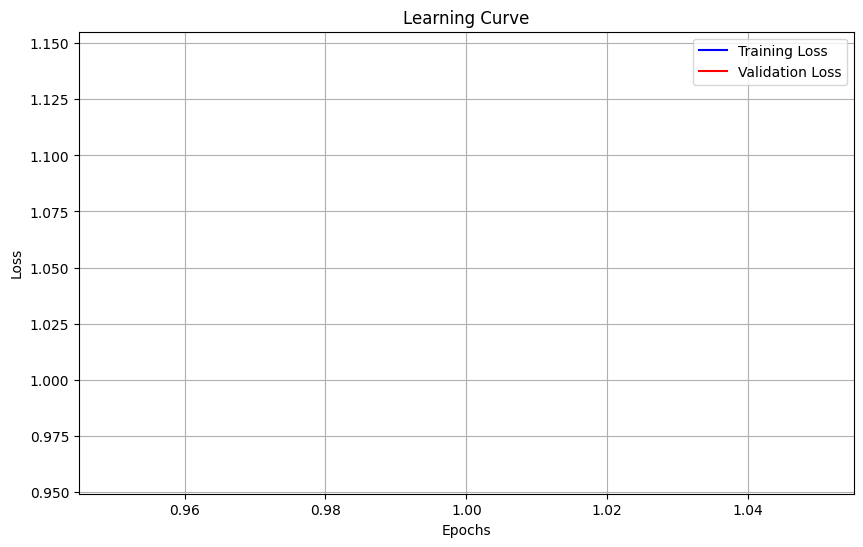

In [18]:
plot_learning_curve(
    train_losses,
    valid_losses,
)

In [19]:
test(
    test_loader,
    model,
    criterion,
    device
)

100%|█████████████████████████████████████████| 334/334 [36:21<00:00,  6.53s/it]

Test Loss: 0.96201650664478, Test Accuracy: 0.7085516467065869


In [20]:
test(
    valid_loader,
    model, 
    criterion,
    device
)

100%|█████████████████████████████████████████| 334/334 [36:18<00:00,  6.52s/it]

Test Loss: 0.9585873541717758, Test Accuracy: 0.7088635229540918


In [25]:
# Import nn module from torch
import torch.nn as nn

# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
# # Example of target with class probabilities
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5).softmax(dim=1)
# output = loss(input, target)
# output.backward()

In [26]:
input.shape

torch.Size([3, 5])

In [27]:
target.shape

torch.Size([3])